In [1]:
%%capture

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

from model import LSTMBaseModel, RNNBaseModel
from train import RNNTrainer

%run etl_feature.ipynb
%run etl_load.ipynb

### Index Normalizing

In [2]:
def upsample_to_hourly(df):
    if pd.infer_freq(df.index) == 'D':
        return df.resample('H').ffill() 
    return df

df_weather = upsample_to_hourly(df_weather)
df_cloud = upsample_to_hourly(df_cloud)

/var/folders/fx/vf6fk88550923hfq9c5dw5pm0000gn/T/ipykernel_13256/2070566789.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.resample('H').ffill()


In [3]:
def _split(df: pd.DataFrame, target_col: str):    
    df = df.sort_index()

    features = df.drop(columns=[target_col])
    target = df[[target_col]]  

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Create sequences
    def create_sequences(X, y, window_size):
        Xs, ys = [], []
        for i in range(len(X) - window_size):
            Xs.append(X[i:i+window_size])
            ys.append(y[i+window_size])
        return np.array(Xs), np.array(ys)

    window_size = 24  # Use 24 hours of data
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

    # Train/test split
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    return X_train, X_test, y_train, y_test, window_size, split, scaler_y
def _decompose(df: pd.DataFrame) -> pd.DataFrame:
    df["hour"] = df.index.hour
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["month"] = df.index.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df = df.drop(columns=["hour", "month"])

    return df


### Modeling ERCOT Solar Generation

In [4]:
df_solar_features = df_solar[["ERCOT.PVGR.GEN", "Total Solar Installed, MW"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "snow"]]
df_cloud_features = df_cloud["Cloud Coverage"]

df_solar_features = df_solar_features[~df_solar_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]
df_cloud_features = df_cloud_features[~df_cloud_features.index.duplicated(keep='first')]

df = pd.concat([df_solar_features, df_weather_features, df_cloud_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling


In [5]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y = _split(df = df, target_col="ERCOT.PVGR.GEN")

Epoch 1/20 | Train Loss: 0.7554 | Val Loss: 1.2122
Epoch 2/20 | Train Loss: 0.7065 | Val Loss: 1.2514
Epoch 3/20 | Train Loss: 0.6925 | Val Loss: 1.2325
Epoch 4/20 | Train Loss: 0.6828 | Val Loss: 1.2593
Epoch 5/20 | Train Loss: 0.6689 | Val Loss: 1.2452
Epoch 6/20 | Train Loss: 0.6583 | Val Loss: 1.2755
Epoch 7/20 | Train Loss: 0.6591 | Val Loss: 1.2057
Epoch 8/20 | Train Loss: 0.6494 | Val Loss: 1.1939
Epoch 9/20 | Train Loss: 0.6244 | Val Loss: 1.2541
Epoch 10/20 | Train Loss: 0.6004 | Val Loss: 1.2119
Epoch 11/20 | Train Loss: 0.5845 | Val Loss: 1.2184
Epoch 12/20 | Train Loss: 0.5492 | Val Loss: 1.3774
Epoch 13/20 | Train Loss: 0.5329 | Val Loss: 1.1585
Epoch 14/20 | Train Loss: 0.5185 | Val Loss: 1.1481
Epoch 15/20 | Train Loss: 0.4952 | Val Loss: 1.2117
Epoch 16/20 | Train Loss: 0.4722 | Val Loss: 1.0473
Epoch 17/20 | Train Loss: 0.4549 | Val Loss: 1.2301
Epoch 18/20 | Train Loss: 0.4424 | Val Loss: 1.0779
Epoch 19/20 | Train Loss: 0.4260 | Val Loss: 1.0626
Epoch 20/20 | Train L

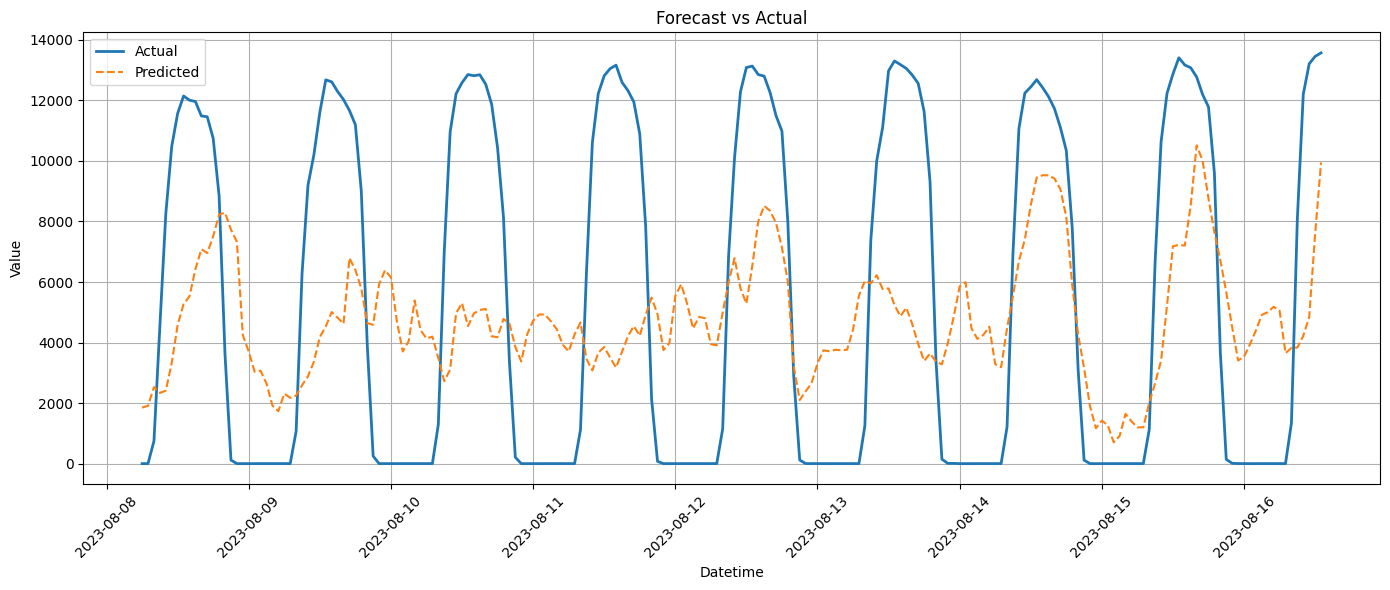

In [6]:
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)


Epoch 1/30 | Train Loss: 0.7471 | Val Loss: 1.1738
Epoch 2/30 | Train Loss: 0.6448 | Val Loss: 1.1026
Epoch 3/30 | Train Loss: 0.5640 | Val Loss: 1.1326
Epoch 4/30 | Train Loss: 0.4820 | Val Loss: 1.0744
Epoch 5/30 | Train Loss: 0.4038 | Val Loss: 0.9824
Epoch 6/30 | Train Loss: 0.3518 | Val Loss: 1.0745
Epoch 7/30 | Train Loss: 0.3161 | Val Loss: 0.8367
Epoch 8/30 | Train Loss: 0.2881 | Val Loss: 0.9932
Epoch 9/30 | Train Loss: 0.2735 | Val Loss: 0.9314
Epoch 10/30 | Train Loss: 0.2488 | Val Loss: 0.9102
Epoch 11/30 | Train Loss: 0.2231 | Val Loss: 0.9749
Epoch 12/30 | Train Loss: 0.2275 | Val Loss: 1.1441
Epoch 13/30 | Train Loss: 0.2062 | Val Loss: 1.1654
Epoch 14/30 | Train Loss: 0.2129 | Val Loss: 1.2668
Epoch 15/30 | Train Loss: 0.1857 | Val Loss: 1.4342
Epoch 16/30 | Train Loss: 0.1819 | Val Loss: 1.0775
Epoch 17/30 | Train Loss: 0.1671 | Val Loss: 1.5999
Epoch 18/30 | Train Loss: 0.1573 | Val Loss: 1.5423
Epoch 19/30 | Train Loss: 0.1567 | Val Loss: 2.2635
Epoch 20/30 | Train L

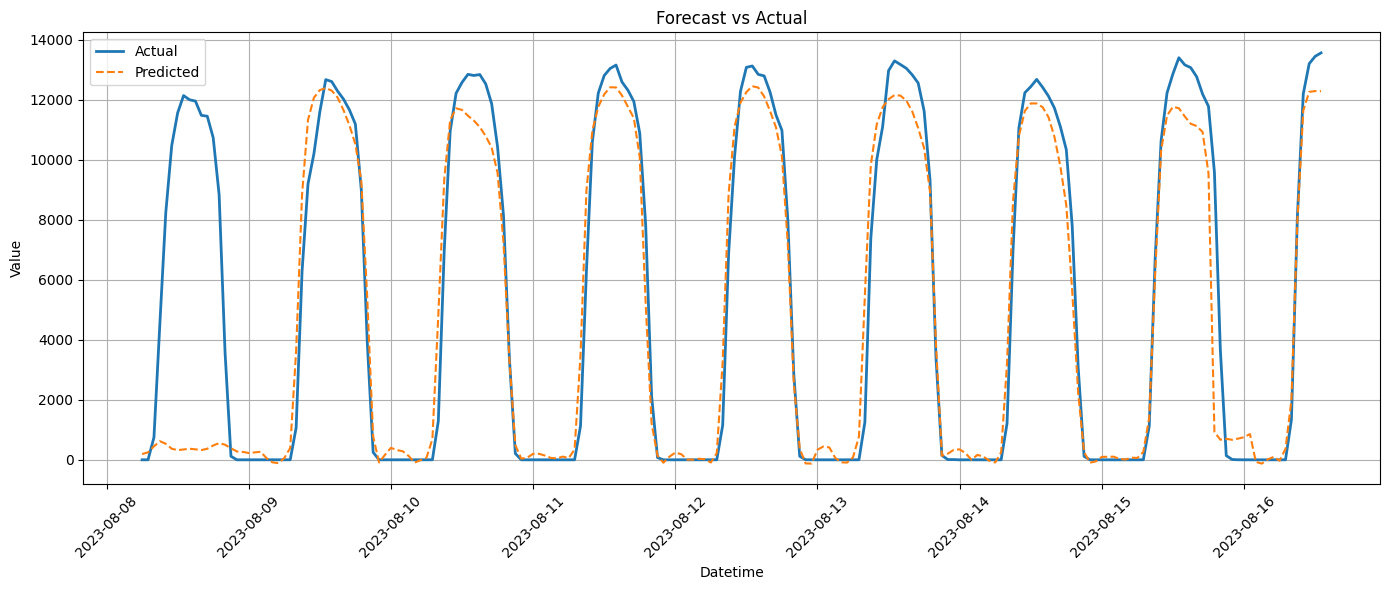

In [7]:
df = _decompose(df)

model = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=30)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

### Modeling Wind Generation

In [16]:
df_wind_features = df_wind[["ERCOT.WIND.GEN", "Total Wind Installed, MW"]]
df_wind_weather_features = df_weather[["snow", "wdir", "wspd"]]

df_wind_features = df_wind_features[~df_wind_features.index.duplicated(keep='first')]
df_wind_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]

df = pd.concat([df_wind_features, df_weather_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling

In [17]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y = _split(df = df, target_col="ERCOT.WIND.GEN")

Epoch 1/20 | Train Loss: 0.4895 | Val Loss: 0.5125
Epoch 2/20 | Train Loss: 0.4345 | Val Loss: 0.5164
Epoch 3/20 | Train Loss: 0.4201 | Val Loss: 0.5037
Epoch 4/20 | Train Loss: 0.4131 | Val Loss: 0.5234
Epoch 5/20 | Train Loss: 0.4047 | Val Loss: 0.5088
Epoch 6/20 | Train Loss: 0.4000 | Val Loss: 0.4991
Epoch 7/20 | Train Loss: 0.3894 | Val Loss: 0.5282
Epoch 8/20 | Train Loss: 0.3792 | Val Loss: 0.4935
Epoch 9/20 | Train Loss: 0.3668 | Val Loss: 0.5191
Epoch 10/20 | Train Loss: 0.3618 | Val Loss: 0.5456
Epoch 11/20 | Train Loss: 0.3574 | Val Loss: 0.5098
Epoch 12/20 | Train Loss: 0.3547 | Val Loss: 0.5020
Epoch 13/20 | Train Loss: 0.3424 | Val Loss: 0.5703
Epoch 14/20 | Train Loss: 0.3419 | Val Loss: 0.4867
Epoch 15/20 | Train Loss: 0.3357 | Val Loss: 0.5197
Epoch 16/20 | Train Loss: 0.3281 | Val Loss: 0.5412
Epoch 17/20 | Train Loss: 0.3199 | Val Loss: 0.5820
Epoch 18/20 | Train Loss: 0.3147 | Val Loss: 0.5821
Epoch 19/20 | Train Loss: 0.3143 | Val Loss: 0.5133
Epoch 20/20 | Train L

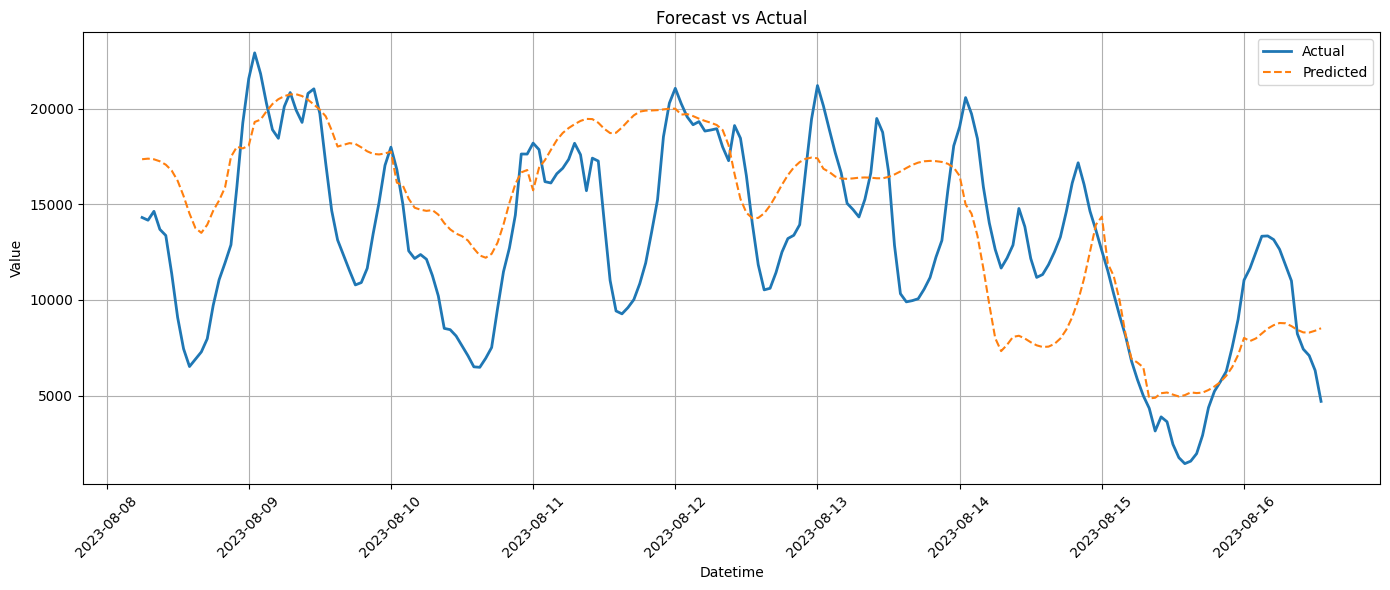

In [18]:
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)


Epoch 1/30 | Train Loss: 0.4581 | Val Loss: 0.5390
Epoch 2/30 | Train Loss: 0.4007 | Val Loss: 0.6001
Epoch 3/30 | Train Loss: 0.3766 | Val Loss: 0.5143
Epoch 4/30 | Train Loss: 0.3462 | Val Loss: 0.4677
Epoch 5/30 | Train Loss: 0.3250 | Val Loss: 0.4803
Epoch 6/30 | Train Loss: 0.2955 | Val Loss: 0.5554
Epoch 7/30 | Train Loss: 0.2653 | Val Loss: 0.5750
Epoch 8/30 | Train Loss: 0.2415 | Val Loss: 0.5218
Epoch 9/30 | Train Loss: 0.2206 | Val Loss: 0.5184
Epoch 10/30 | Train Loss: 0.2044 | Val Loss: 0.5195
Epoch 11/30 | Train Loss: 0.1833 | Val Loss: 0.5940
Epoch 12/30 | Train Loss: 0.1672 | Val Loss: 0.6173
Epoch 13/30 | Train Loss: 0.1556 | Val Loss: 0.6776
Epoch 14/30 | Train Loss: 0.1408 | Val Loss: 0.6478
Epoch 15/30 | Train Loss: 0.1304 | Val Loss: 0.6503
Epoch 16/30 | Train Loss: 0.1206 | Val Loss: 0.6367
Epoch 17/30 | Train Loss: 0.1091 | Val Loss: 0.6302
Epoch 18/30 | Train Loss: 0.1041 | Val Loss: 0.5819
Epoch 19/30 | Train Loss: 0.0936 | Val Loss: 0.6393
Epoch 20/30 | Train L

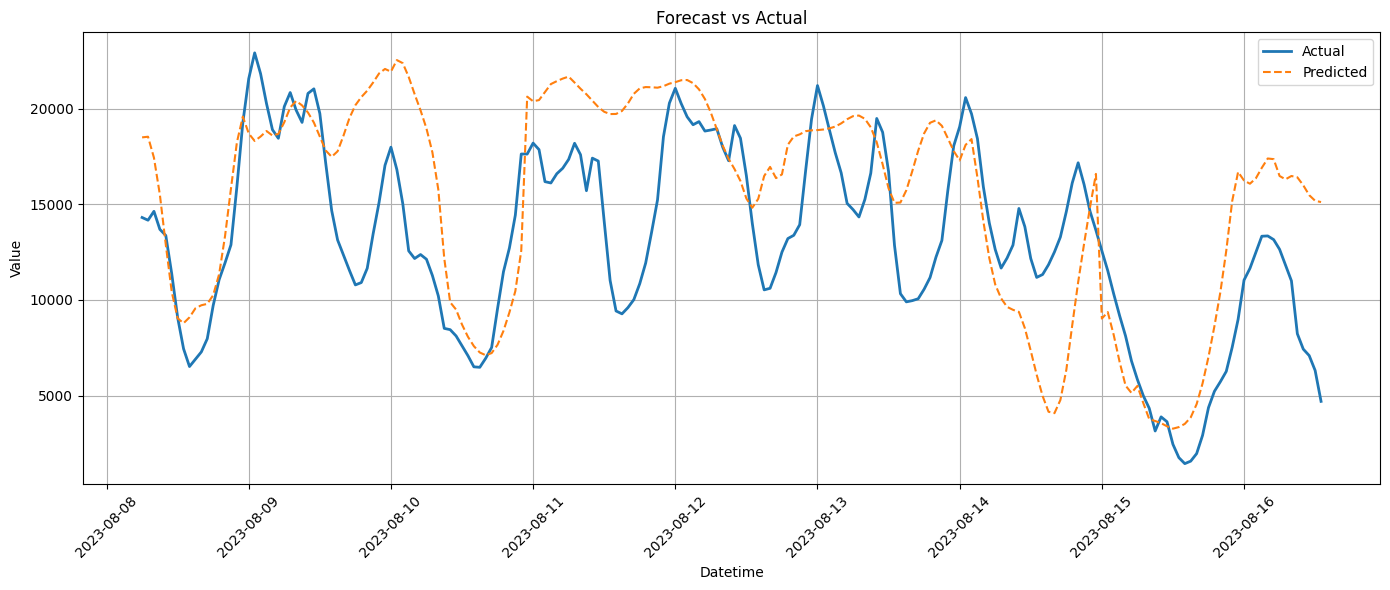

In [19]:
df = _decompose(df)

model = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=30)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)

### Load forecasting

In [12]:
df_load_features = df_load[["ERCOT"]]
df_weather_features = df_weather[["tavg", "tmin", "tmax", "prcp", "wdir", "wspd"]]

df_load_features = df_load_features[~df_load_features.index.duplicated(keep='first')]
df_weather_features = df_weather_features[~df_weather_features.index.duplicated(keep='first')]

df = pd.concat([df_load_features, df_weather_features], axis=1, join="inner")
df.fillna(0) #NA created from ramps 
df = df.dropna()  # BEFORE scaling
df

,ERCOT,tavg,tmin,tmax,prcp,wdir,wspd
2022-01-01 01:00:00,38006.938896,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 02:00:00,37036.522365,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 03:00:00,35881.607998,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 04:00:00,35044.055105,16.06,2.91,22.18,0.66,272.3,22.24
2022-01-01 05:00:00,34585.571140,16.06,2.91,22.18,0.66,272.3,22.24
...,...,...,...,...,...,...,...
2023-12-28 00:00:00,46472.957947,7.07,1.16,12.88,0.00,279.4,12.24
2023-12-29 00:00:00,47912.210531,6.55,0.44,14.69,0.00,247.5,12.76
2023-12-30 00:00:00,47741.831804,8.62,0.46,18.83,0.00,244.1,7.99
2023-12-31 00:00:00,44742.203232,10.94,3.55,18.94,0.00,172.1,10.87


In [13]:
X_train, X_test, y_train, y_test, window_size, split, scaler_y  = _split(df = df, target_col="ERCOT")

Epoch 1/20 | Train Loss: 0.4603 | Val Loss: 0.4875
Epoch 2/20 | Train Loss: 0.4166 | Val Loss: 0.4837
Epoch 3/20 | Train Loss: 0.4138 | Val Loss: 0.4692
Epoch 4/20 | Train Loss: 0.4076 | Val Loss: 0.4244
Epoch 5/20 | Train Loss: 0.4042 | Val Loss: 0.4333
Epoch 6/20 | Train Loss: 0.3926 | Val Loss: 0.4625
Epoch 7/20 | Train Loss: 0.3962 | Val Loss: 0.4533
Epoch 8/20 | Train Loss: 0.3657 | Val Loss: 0.3805
Epoch 9/20 | Train Loss: 0.3368 | Val Loss: 0.3903
Epoch 10/20 | Train Loss: 0.3168 | Val Loss: 0.3528
Epoch 11/20 | Train Loss: 0.2912 | Val Loss: 0.3774
Epoch 12/20 | Train Loss: 0.2745 | Val Loss: 0.3113
Epoch 13/20 | Train Loss: 0.2644 | Val Loss: 0.2847
Epoch 14/20 | Train Loss: 0.2398 | Val Loss: 0.3080
Epoch 15/20 | Train Loss: 0.2304 | Val Loss: 0.2547
Epoch 16/20 | Train Loss: 0.2052 | Val Loss: 0.2582
Epoch 17/20 | Train Loss: 0.2005 | Val Loss: 0.2867
Epoch 18/20 | Train Loss: 0.1933 | Val Loss: 0.2659
Epoch 19/20 | Train Loss: 0.1845 | Val Loss: 0.2086
Epoch 20/20 | Train L

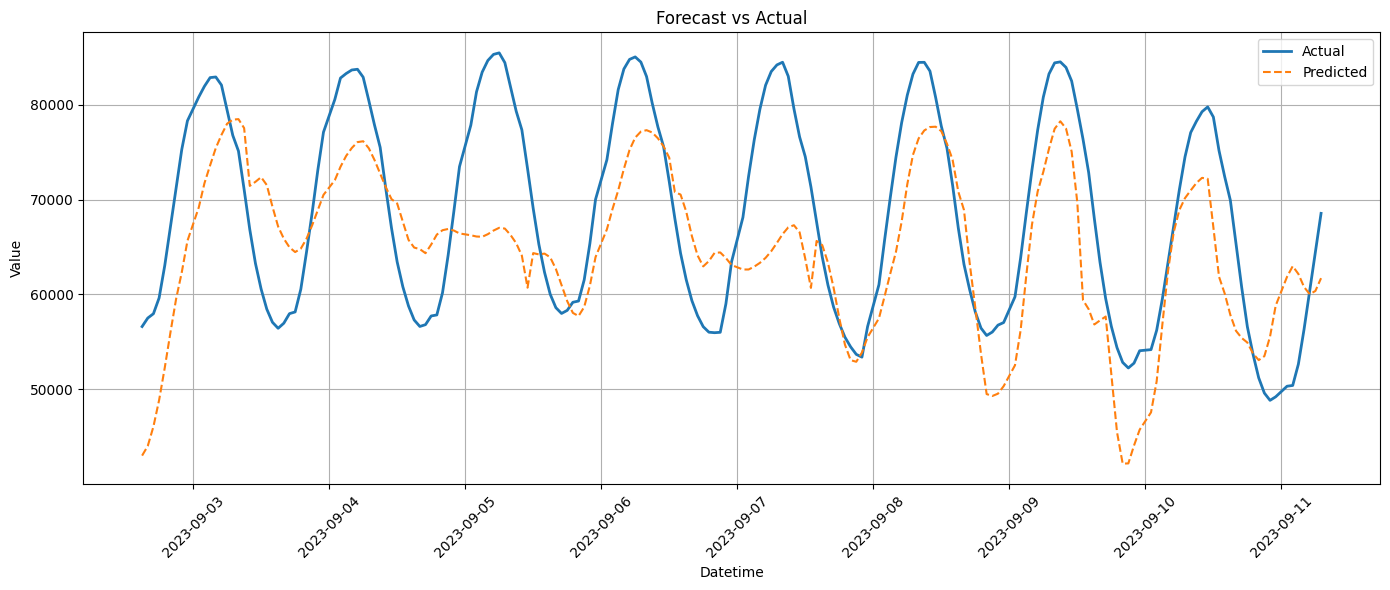

In [14]:
model = RNNBaseModel(input_size=X_train.shape[2], hidden_size=64)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=20)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)


Epoch 1/30 | Train Loss: 0.4387 | Val Loss: 0.5765
Epoch 2/30 | Train Loss: 0.4032 | Val Loss: 0.5406
Epoch 3/30 | Train Loss: 0.4013 | Val Loss: 0.4670
Epoch 4/30 | Train Loss: 0.3902 | Val Loss: 0.4573
Epoch 5/30 | Train Loss: 0.3025 | Val Loss: 0.3212
Epoch 6/30 | Train Loss: 0.2058 | Val Loss: 0.2747
Epoch 7/30 | Train Loss: 0.1502 | Val Loss: 0.1819
Epoch 8/30 | Train Loss: 0.1187 | Val Loss: 0.1465
Epoch 9/30 | Train Loss: 0.0956 | Val Loss: 0.2148
Epoch 10/30 | Train Loss: 0.0743 | Val Loss: 0.1489
Epoch 11/30 | Train Loss: 0.0607 | Val Loss: 0.1504
Epoch 12/30 | Train Loss: 0.0522 | Val Loss: 0.1262
Epoch 13/30 | Train Loss: 0.0475 | Val Loss: 0.1066
Epoch 14/30 | Train Loss: 0.0419 | Val Loss: 0.1428
Epoch 15/30 | Train Loss: 0.0390 | Val Loss: 0.1167
Epoch 16/30 | Train Loss: 0.0370 | Val Loss: 0.1144
Epoch 17/30 | Train Loss: 0.0324 | Val Loss: 0.1184
Epoch 18/30 | Train Loss: 0.0326 | Val Loss: 0.1311
Epoch 19/30 | Train Loss: 0.0297 | Val Loss: 0.1249
Epoch 20/30 | Train L

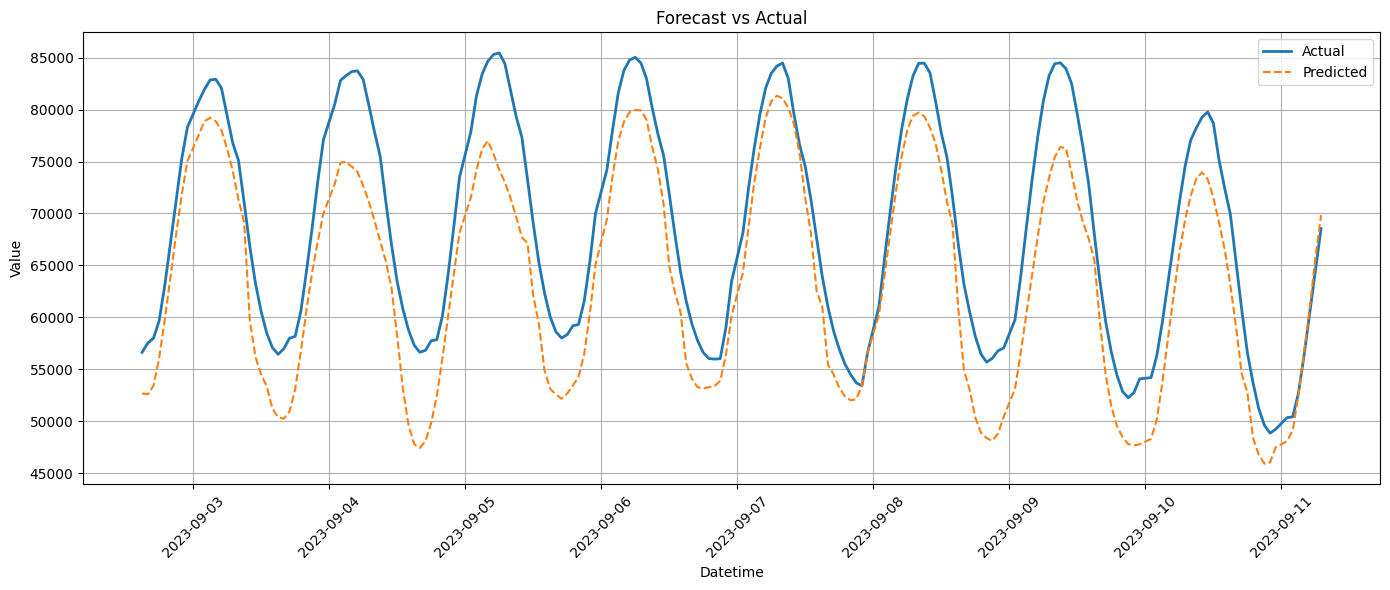

In [15]:
df = _decompose(df)

model = LSTMBaseModel(input_size=X_train.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
trainer = RNNTrainer(model)
trainer.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=30)
test_index = df.index[window_size + split : window_size + split + len(y_test)]
trainer.plot_forecast(X_test, y_test, y_scaler=scaler_y, datetime_index=test_index)